# AML Package for Text Analytics - Custom Entity Extration
### Entity extraction using Recurrent Neural Networks (RNNs) and Word2Vec Embeddings

This notebook demonstrates how to use pre-trained Word2Vec word embeddings model to train a custom entity extraction model using the **Azure Machine Learning Package for Text Analytics** (AMLPTA)

The entity extractor uses APIs which call Keras wtih Tensorflow backend for training and prediction. The pipeline for entity extraction can be saved, and reloaded for later use in predictions on new datasets.

Entity extraction is a subtask of information extraction (also known as Named-entity recognition (NER), entity chunking and entity identification). It consists of locating and classifying entities in a text into pre-defined categories. 

In an entity recognition task, there is exactly one tag per word. A tag and can have one of the values (often referred to as IOB format):
- `B-<entity_type>` -- refers to the beginning of an entity phrase of type `<entity_type>` <br>
- `I-<entity_type>` -- refers to a non-initial part of an entity phrase of type `<entity_type>` <br>
- `O` -- refers to a word outside of any phrase of interest. <br>

`<entity_type>` is one of the entity types of interest. for illustration, we use Semeval 2013 drug recognition dataset, which has one entity type: *Drug*. Therefore, allowed tags are: <br>
`B-Drug`, `I-Drug`, and `O`. <br>

Recurrent Neural Networks (RNNs) are neural network models typically used for sequence labeling tasks such as entity extraction. In RNNs, connections between units form a directed graph along a sequence, allowing then to exhibit dynamic temporal behavior of a sequence. In the context of text data, each time step is a word along the sentence. 

As an input to the RNN, each word will be represented by its embedding vector given by a pre-trained Word2Vec embedding model. This model, pre-trained on a large corpus, learns words representations that incorporate information about their context. For memory efficiency, and since the embeddings are fixed in this tutorial, no Embedding Layer is used: word vectors are directly fed to the model as inputs.  

In this notebook, an entity extraction pipeline is implemented in the class `KerasEntityExtractor`. It consists of the following main steps:
- `NltkPreprocessor`, which tokenizes and splits the input in sentences.
- `NltkPosVectorizer` (Optional), which adds part of speech features for the tokens (e.g. noun, adjective).
- `WordTypeFeature` (Optional), which adds the word type as a feature (e.g. word, number, symbol, punctuation). 
- `OrthographicFeature` (Optional), which adds orthographic features for the tokens (e.g. all capital, all lower case).
- `Word2VecVectorizer` (Optional), which assigns to each word its embedding feature from the pre-trained Word2Vec model. 
- `ClusterEmbeddingFeature` (Optional), which assigns the embeddings to clusters trained on the embedding matrix.
- `KerasSequenceTagger`, which pads the features and trains an RNN model using Keras with Tensorflow backend. The model is then used at prediction time. 

This notebook uses Word2Vec embeddings pre-trained on a large corpus of biomedical (PubMed abstracts) data, according to the process summarized in the picture below.

Following are the steps for creating and deploying a custom entity extraction model using the package:
<br> Step 1: Loading dataset and pre-trained embedding model
<br> Step 2: Model training
<br> Step 3: Apply the custom entity extractor 
<br> Step 4: Performance Evaluation
<br> Step 5: Save the pipeline 
<br> Step 6: Load the pipeline 
<br> Step 7: Run the pipeline on new data
<br> Step 8: Operationalize - Deploy the pipeline

Consult the [package reference documentation](https://aka.ms/aml-packages/text) for the detailed reference for each module and class.

## Prerequisites 

1. If you don't have an Azure subscription, create a [free account](https://azure.microsoft.com/free/?WT.mc_id=A261C142F) before you begin.

1. The following accounts and application must be set up and installed:
   - Azure Machine Learning Experimentation account 
   - An Azure Machine Learning Model Management account
   - Azure Machine Learning Workbench installed

   If these three are not yet created or installed, follow the [Azure Machine Learning Quickstart and Workbench installation](../service/quickstart-installation.md) article. 

1. The Azure Machine Learning Package for Text Analytics must be installed. Learn how to [install this package here](https://aka.ms/aml-packages/text).

### Configure and import libraries

In [1]:
# Import Packages 
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
#%azureml history on
%matplotlib inline
# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
import os
import warnings
logger = get_azureml_logger()

# Log cell runs into run history
logger.log('Cell','Set up run')

warnings.filterwarnings("ignore")

---
Metadata-Version: 2.0
Name: azureml-tatk
Version: 0.1.18121.30a1
Summary: Microsoft Azure Machine Learning Package for Text Analytics
Home-page: https://microsoft.sharepoint.com/teams/TextAnalyticsPackagePreview
Author: Microsoft Corporation
Author-email: amltap@microsoft.com
Installer: pip
License: UNKNOWN
Location: c:\users\tatk\appdata\local\amlworkbench\python\lib\site-packages
Requires: azure-storage, matplotlib, validators, pdfminer.six, dill, azure-ml-api-sdk, pandas, requests, qgrid, nose, bqplot, unidecode, ipywidgets, docker, nltk, scipy, keras, scikit-learn, jsonpickle, ruamel.yaml, numpy, gensim, h5py, ipython, pytest, pyspark, lxml, sklearn-crfsuite
Classifiers:


You are using pip version 8.1.2, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Step 1: Loading dataset and pre-trained embedding model
#### Download the semeval drug recognition data set and convert it into dataframes. 
This data set is used for illustration. Please feel free to replace it with your own dataset.


Download the Pubmed/Medline data from SemEval-13 task9 from https://www.cs.york.ac.uk/semeval-2013/task9/data/uploads/datasets/train/semeval_task9_train.zip .

Extract the zip file and set `extracted_location` to point to the folder where it is extracted.

In [2]:
import os

extracted_location = r"C:\Users\tatk\Downloads"

xml_folder_1 = os.path.join(extracted_location, "semeval_task9_train", "Train", "DrugBank")
xml_folder_2 = os.path.join(extracted_location, "semeval_task9_train", "Train", "MedLine")

xml_folders = [xml_folder_1, xml_folder_2]

Convert the data from xml files to the train and test data files in the BIO format described above. Each file is a text file with 2 columns: word and label. An empty line separates two documents or sentences.

In [3]:
from tatk.utils.parse_semeval_data import create_semeval_train_and_test_datasets

train_dataset_path = os.path.join(extracted_location, "semeval_train.txt")
test_dataset_path = os.path.join(extracted_location, "semeval_test.txt")
train_ratio = 0.8 # The ratio of the number of files takes for train dataset.

overwrite = False # Set to True if you want to generate the data again

if not os.path.exists(train_dataset_path) or not os.path.exists(test_dataset_path) or overwrite:
    create_semeval_train_and_test_datasets(xml_folders, train_dataset_path, test_dataset_path, train_ratio)

BioDataReader loads the data in the BIO format. Set take_subset to False if you want to use the full data.

In [4]:
take_subset = True

from tatk.utils import resources_dir, data_dir, models_dir
from tatk.ingestion.bio_format_data_reader import BioDataReader    

X_train, y_train = BioDataReader(train_dataset_path).get_data() 
X_test, y_test = BioDataReader(test_dataset_path).get_data() 

# We loop over the data and remove '#':
X_train = [[X_train[i][j] if X_train[i][j] != '#' else 'hash' for j in range(len(X_train[i]))] for i in range(len(X_train))]
X_test = [[X_test[i][j] if X_test[i][j] != '#' else 'hash' for j in range(len(X_test[i]))] for i in range(len(X_test))]

# Create Pandas Dataframes as input into the package functions
if take_subset:
    df_train = pd.DataFrame({"text":X_train[:3000], "label":y_train[:3000]})
    df_test = pd.DataFrame({"text":X_test[:1000], "label":y_test[:1000]})
else:
    df_train = pd.DataFrame({"text":X_train, "label":y_train})
    df_test = pd.DataFrame({"text":X_test, "label":y_test})


raw_nd = 5502
raw_nd = 1403


#### Examine training data labels

In [5]:
print(X_train[0])
print(y_train[0])

['Metformin', ':', 'In', 'healthy', 'subjects', 'given', 'single', '500', 'mg', 'doses', 'of', 'cephalexin', 'and', 'metformin', ',', 'plasma', 'metformin', 'mean', 'cmax', 'and', 'AUC', 'increased', 'by', 'an', 'average', 'of', '34', '%', 'and', '24', '%,', 'respectively', ',', 'and', 'metformin', 'mean', 'renal', 'clearance', 'decreased', 'by', '14', '%.']
['B-Drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'O', 'B-Drug', 'O', 'O', 'B-Drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Show class distribution.

{'O': 108684, 'I-Drug': 3578, 'B-Drug': 11971}


Text(0.5,1,'Class Distribution of training data')

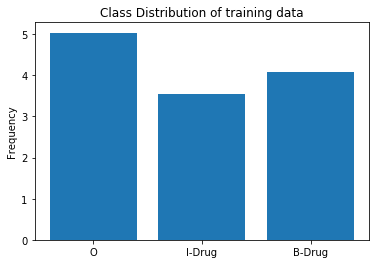

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

def get_frequency(row, count):
    
    for x in row:
        if x in count:
            count[x] = count[x]+1
        else:
            count[x] =1

count = {}
for row in y_train:
    get_frequency(row, count) 

y_pos = np.arange(len(count))
print(count)   
frequency = list(count.values())

log_frequency= [math.log10(x) for x in frequency]

plt.bar(y_pos, log_frequency)
plt.xticks(y_pos, list(count.keys()))
plt.ylabel('Frequency')
plt.title('Class Distribution of training data')

#### Download Word2Vec word embedding model

Download pretrained pubmed word embedding model ``biomedical_word2vec_model.txt`` from
https://datasets4tatk.blob.core.windows.net/word-embedding/PubMed_Models/biomedical_word2vec_model.txt.

This embedding model was trained on MEDLINE abstract data from [MEDLINE](https://www.nlm.nih.gov/pubs/factsheets/medline.html). The data is publicly available in the form of XML files on their [FTP server](https://ftp.ncbi.nlm.nih.gov/pubmed/baseline). There are 892 XML files available on the server and each of the XML files has the information of 30,000 articles.

Set `embedding_file_path` to point to the extracted ``biomedical_word2vec_model.txt`` file.

In [7]:
embedding_file_path = r"C:\Users\tatk\Downloads\biomedical_word2vec_model.txt"

## Step 2: Model training
#### Define entity extractor pipeline.

In [8]:
from tatk.pipelines.entity_extraction.keras_entity_extractor import KerasEntityExtractor

binary_format = False # Pubmed embedding model is not in binary format
limit = None # We load the full model.

keras_entity_recognizer = KerasEntityExtractor(input_col="text",
                                               label_col="label", 
                                               include_embeddings=True,
                                               embedding_file_path=embedding_file_path,
                                               binary_format=binary_format,
                                               embedding_type='word2vec',limit=limit,
                                               include_pos_features=True,
                                               include_wordtype_features=True,
                                               include_orthographic_features=True,
                                               include_embedding_cluster_id=True)

KerasEntityExtractor::create_pipeline ==> start
Word2VecVectorizer::load_embeddings ==> start
Time taken: 0.08 mins
Word2VecVectorizer::load_embeddings ==> end
number of words = 84065
:: number of jobs for the pipeline : 6
0	nltk_preprocessor
1	pos_tagger
2	wordtype_featurizer
3	orthographic_featurizer
4	vectorizer
5	cluster_embeddings_ids
6	learner
KerasEntityExtractor::create_pipeline ==> end


#### Export the parameters to a file

In [9]:
params_file_path = os.path.join(data_dir, "entity_extraction_params.tsv")
keras_entity_recognizer.export_params(params_file_path)

#### Change the parameters of the training pipeline
In particular, the type of training layers (LSTM, or RNN, or GRU) can be specified with set_step_params_by_name.

In [13]:
# for fast training, you can use the following parameters to train a vanilla uni-directional RNN model: 
keras_entity_recognizer.set_step_params_by_name("learner", 
                                                 model__recurrence_type = 'RNN', 
                                                 model__bidirectional= True, #False, 
                                                 batch_size = 50, 
                                                 n_epochs = 5)

# To achieve good results, you can use the following parameters to train a bi-directional LSTM model: 
#keras_entity_recognizer.set_step_params_by_name("learner", 
#                                                model__recurrence_type = 'LSTM', 
#                                                model__bidirectional = True, 
#                                                batch_size = 50, 
#                                                n_epochs = 5)

In [14]:
keras_entity_recognizer.get_step_params_by_name("learner")

{'batch_size': 50,
 'callbacks_list': None,
 'cuda_devices': '0',
 'feature_cols': ['features',
  'NltkPosVectorizerd83b96a4549f46bab7782db2a5ceed05',
  'WordTypeFeature21e2f899017944d89d98c15433e01d53',
  'OrthographicFeature8e2e4efa33734b3da399e4346fef2bfd',
  'ClusterEmbeddingIdFeaturee960f3b917924e6db29371a6581235c9'],
 'label_col': 'label',
 'labels': ['O', 'I-Drug', 'B-Drug', '<OOL>'],
 'log_path': 'C:\\Users\\tatk\\tatk\\resources\\logs',
 'model__bidirectional': True,
 'model__dropout_rate': 0.2,
 'model__n_recurrent_layers': 2,
 'model__n_recurrent_units': 150,
 'model__recurrence_type': 'RNN',
 'model_fn': <function tatk.estimators.keras_model_functions.keras_sequence_tagger_fn.keras_sequence_tagger_fn(with_embedding_layer, model_params, n_labels, num_features=None)>,
 'n_epochs': 5,
 'prediction_col': 'prediction',
 'probabilities_col': 'probabilities',
 'validation_split': 0.1}

#### Note: Current model has 2 stacked bidirectional LSTM layers + Dropout Layer + Dense + Softmax, with categorical_crossentropy loss.    

#### The deep learning model structure can be modified by the user:

1. Define a new model function: model_fn
2. Set it as a parameter to the model with  

keras_entity_recognizer.set_step_params_by_name("learner", model__model_fn = model_fn)     

#### Fit entity extractor model with Keras, Tensorflow backend, and LSTM layers

In [15]:
keras_entity_recognizer.fit(df_train)

KerasEntityExtractor::fit ==> start
schema: col=label:TX:0 col=text:TX:1 col=NltkPreprocessor1cebea17658e49849cf9648c7e1fe9f9:TX:2 header+
NltkPreprocessor::tatk_fit_transform ==> start
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.0 mins
NltkPosVectorizer::tatk_fit_transform ==> startWordTypeFeature::tatk_fit_transform ==> startOrthographicFeature::tatk_fit_transform ==> startWord2VecVectorizer::tatk_fit_transform ==> start



OrthographicFeature::tatk_fit_transform ==> end 	 Time taken: 0.0 minsWordTypeFeature::tatk_fit_transform ==> end 	 Time taken: 0.0 mins

Word2VecVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.03 mins
ClusterEmbeddingIdFeature::tatk_fit_transform ==> start
ClusterEmbeddingIdFeature::tatk_fit_transform ==> end 	 Time taken: 0.07 mins
NltkPosVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.19 mins
KerasSequenceTagger::tatk_fit ==> start
_________________________________________________________________
Layer (type)                 Outpu

KerasEntityExtractor(binary_format=False, callbacks=False,
           cluster_model_path=None, cuda_devices='0',
           dictionary_file_paths=None,
           embedding_file_path='C:\\Users\\tatk\\Downloads\\biomedical_word2vec_model.txt',
           embedding_type='word2vec', include_dictionary_lookup=False,
           include_embedding_cluster_id=True, include_embeddings=True,
           include_orthographic_features=True, include_pos_features=True,
           include_wordtype_features=True, input_col='text',
           label_col='label', limit=None,
           log_dir='C:\\Users\\tatk\\tatk\\resources\\logs')

## Step 3: Apply the custom entity extractor
Apply the trained text classifier to predict entitites in the test dataset 

In [16]:
predictions = keras_entity_recognizer.predict(df_test)
predictions[['text', 'label', 'prediction', 'confidences']][:5]

KerasEntityExtractor ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
NltkPosVectorizer::tatk_transform ==> startWordTypeFeature::tatk_transform ==> startOrthographicFeature::tatk_transform ==> startWord2VecVectorizer::tatk_transform ==> start



WordTypeFeature::tatk_transform ==> end 	 Time taken: 0.0 minsOrthographicFeature::tatk_transform ==> end 	 Time taken: 0.0 mins

Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.01 mins
ClusterEmbeddingIdFeature::tatk_transform ==> start
ClusterEmbeddingIdFeature::tatk_transform ==> end 	 Time taken: 0.02 mins
NltkPosVectorizer::tatk_transform ==> end 	 Time taken: 0.06 mins
KerasSequenceTagger::tatk_predict_proba ==> start
KerasSequenceTagger::tatk_predict_proba ==> end 	 Time taken: 0.04 mins
KerasSequenceTagger::tatk_predict ==> start
KerasSequenceTagger::tatk_predict ==> end 	 Time taken: 0.03 mins
Time taken: 0.13 mins
KerasEntityExtractor ::predict =

,text,label,prediction,confidences
0,"[Certain, drugs, tend, to, produce, hyperglyce...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0.9996140599250793, 0.9933236241340637, 0.999..."
1,"[These, drugs, include, the, thiazides, and, o...","[O, O, O, O, B-Drug, O, O, B-Drug, O, B-Drug, ...","[O, O, O, O, B-Drug, O, O, B-Drug, O, B-Drug, ...","[0.9997926354408264, 0.9860085844993591, 0.999..."
2,"[When, such, drugs, are, administered, to, a, ...","[O, O, O, O, O, O, O, O, O, B-Drug, O, O, O, O...","[O, O, O, O, O, O, O, O, O, B-Drug, O, O, O, O...","[0.9997723698616028, 0.9988151788711548, 0.984..."
3,"[When, such, drugs, are, withdrawn, from, pati...","[O, O, O, O, O, O, O, O, B-Drug, O, O, O, B-Dr...","[O, O, O, O, O, O, O, O, B-Drug, O, O, O, B-Dr...","[0.9997610449790955, 0.9990547299385071, 0.990..."
4,"[Intestinal, adsorbents, (, e, ., g, .,, charc...","[B-Drug, I-Drug, O, O, O, O, O, B-Drug, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.8754504919052124, 0.8738599419593811, 0.992..."


## Step 4: Performance evaluation on the test set
Create the evaluator object by applying evaluate on the predictions

In [17]:
evaluator = keras_entity_recognizer.evaluate(predictions)

BaseEntityExtractor::evaluate ==> start
Time taken: 0.0 mins
BaseEntityExtractor::evaluate ==> end


Get phrase level performance metrics.

In [18]:
evaluator.get_metrics('phrase_level_results')

,TP,FP,FN,Recall,Prec.,F-score,RB_TP,RB_FP,RB_FN,RB_Recall,RB_Prec.,RB_F-score,LB_TP,LB_FP,LB_FN,LB_Recall,LB_Prec.,LB_F-score
Drug,1694.0,191.0,326.0,0.838614,0.898674,0.867606,1751.0,134.0,269.0,0.866832,0.928912,0.896799,1747.0,138.0,273.0,0.864851,0.92679,0.89475
ALL,1694.0,191.0,326.0,0.838614,0.898674,0.867606,1751.0,134.0,269.0,0.866832,0.928912,0.896799,1747.0,138.0,273.0,0.864851,0.92679,0.89475


Get word level performance metrics (individual tags aggregated).

In [19]:
evaluator.get_metrics('entity_level_results')

,WEL_TP,WEL_FP,WEL_FN,WEL_Recall,WEL_Prec.,WEL_F-score
Drug,2151.0,113.0,477.0,0.818493,0.950088,0.879395
ALL,2151.0,113.0,477.0,0.818493,0.950088,0.879395


Get tag level performance metrics.

In [20]:
evaluator.get_metrics('tag_level_results')

,WTL_TP,WTL_FP,WTL_FN,WTL_Recall,WTL_Prec.,WTL_F-score
B-Drug,1747.0,87.0,273.0,0.864851,0.952563,0.906591
I-Drug,376.0,54.0,232.0,0.618421,0.874419,0.724470
ALL,2123.0,141.0,505.0,0.807839,0.937721,0.867948


Plot the normalized confusion matrix at the tag level.

Normalized Word_LevelConfusion Matrix
[[ 0.9525627   0.00817884  0.03925845]
 [ 0.03023256  0.8744186   0.09534884]
 [ 0.01244436  0.01038625  0.97716939]]


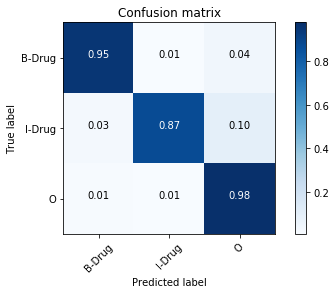

In [21]:
evaluator.plot_confusion_matrix(type='word_level', normalize = True)

Plot the normalized confusion matrix at the entity level.

Normalized Entity_LevelConfusion Matrix
[[ 0.95008834  0.04991166]
 [ 0.02283061  0.97716939]]


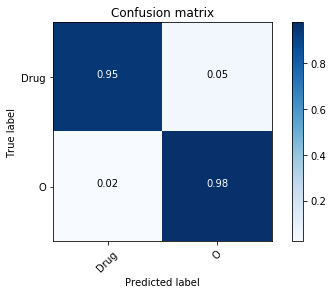

In [22]:
evaluator.plot_confusion_matrix(type='entity_level', normalize = True)

## Step 5: Save the pipeline
Persist the scoring pipeline.

Create a path to save your pipeline and model.

In [23]:
from tatk.utils import data_dir
working_dir = os.path.join(data_dir, 'outputs')  
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
pipeline_zip_file = os.path.join(working_dir, 'keras_w2v_extractor.zip')
print(pipeline_zip_file)

C:\Users\tatk\tatk\resources\data\outputs\keras_w2v_extractor.zip


In [24]:
keras_entity_recognizer.save(pipeline_zip_file, compress_archive = False)

BaseTextModel::save ==> start
TatkPipeline::save ==> start
copy embedding file from  C:\Users\tatk\Downloads\biomedical_word2vec_model.txt
Time taken: 0.0 mins
TatkPipeline::save ==> end
Time taken: 0.01 mins
BaseTextModel::save ==> end


## Step 6: Load the pipeline
Load the scoring pipeline & evaluate performance of entity predictions on test data

In [25]:
# Load pipeline.
loaded_keras_entity_recognizer = KerasEntityExtractor.load(pipeline_zip_file)

# Evaluate again on the testing set.
predictions = loaded_keras_entity_recognizer.predict(df_test)
evaluator2 = loaded_keras_entity_recognizer.evaluate(predictions)
evaluator2.get_metrics('phrase_level_results')[['Recall', 'Prec.', 'F-score']]

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Word2VecVectorizer: Word2Vec model loaded from C:\Users\tatk\tatk\resources\data\outputs\keras_w2v_extractor.zip 2018-05-04 01.24.13\keras_w2v_extractor\pipeline\vectorizer\embedding_table.txt
Time taken: 0.15 mins
TatkPipeline::load ==> end
Time taken: 0.16 mins
BaseTextModel::load ==> end
KerasEntityExtractor ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
NltkPosVectorizer::tatk_transform ==> startWordTypeFeature::tatk_transform ==> startOrthographicFeature::tatk_transform ==> startWord2VecVectorizer::tatk_transform ==> start



OrthographicFeature::tatk_transform ==> end 	 Time taken: 0.0 mins
WordTypeFeature::tatk_transform ==> end 	 Time taken: 0.0 mins
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.01 mins
ClusterEmbeddingIdFeature::tatk_transform ==> start
ClusterEmbeddingIdFeature::tatk_transform ==> end 	 Time taken: 0.02 mins
N

,Recall,Prec.,F-score
Drug,0.838614,0.898674,0.867606
ALL,0.838614,0.898674,0.867606


## Step 7: Run the pipeline on new data

In [26]:
df_predict = pd.DataFrame({'text' : ["I have fever. \
                                     My doctor prescribed ibuprofen."]})
predictions = loaded_keras_entity_recognizer.predict(df_predict)
predictions[['text', 'prediction', 'confidences']]

KerasEntityExtractor ::predict ==> start
SentenceDetector::transform ==> start
GenerateIndexTransformer::tatk_transform ==> start
GenerateIndexTransformer::tatk_transform ==> end 	 Time taken: 0.0 mins
SentenceDetector::transform ==> end
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
NltkPosVectorizer::tatk_transform ==> start
WordTypeFeature::tatk_transform ==> startOrthographicFeature::tatk_transform ==> startWord2VecVectorizer::tatk_transform ==> start


WordTypeFeature::tatk_transform ==> end 	 Time taken: 0.0 minsNltkPosVectorizer::tatk_transform ==> end 	 Time taken: 0.0 minsOrthographicFeature::tatk_transform ==> end 	 Time taken: 0.0 minsWord2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.0 mins



ClusterEmbeddingIdFeature::tatk_transform ==> start
ClusterEmbeddingIdFeature::tatk_transform ==> end 	 Time taken: 0.0 mins
KerasSequenceTagger::tatk_predict_proba ==> start
KerasSequenceTagger::tatk_predict_proba ==

,text,prediction,confidences
0,I have fever. ...,"[O, O, O, O, O, O, O, B-Drug, O]","[0.9089438319206238, 0.9995831847190857, 0.999..."


## Step 8: Operationalization: deploy and consume

In this section, you deploy the text classification pipeline as an Azure Machine Learning web service using [Azure Machine Learning CLI](https://docs.microsoft.com/azure/machine-learning/desktop-workbench/cli-for-azure-machine-learning). Then, you consume the web service for training and scoring.

**Log in to your Azure subscription with Azure CLI**

Using an [Azure](https://azure.microsoft.com/) account with a valid subscription, log in using the following CLI command:
<br>`az login`

+ To switch to another Azure subscription, use the command:
<br>`az account set --subscription [your subscription name]`

+ To see the current model management account, use the command:
  <br>`az ml account modelmanagement show`

**Create and set your deployment environment**

You only need to set your deployment environment once. If you don't have one yet, set up your deployment environment now using [these instructions](https://docs.microsoft.com/azure/machine-learning/desktop-workbench/deployment-setup-configuration#environment-setup). 

1- Make sure your Azure Machine Learning environment, model management account, and resource group are located in the same region.

2- Download the deployment configuration file from Blob storage and save it locally:

In [27]:
# Download the deployment config file from Blob storage `url` and save it locally under `file_name`:
deployment_config_file_url = 'https://aztatksa.blob.core.windows.net/dailyrelease/tatk_deploy_config.yaml'
deployment_config_file_path=os.path.join(resources_dir, 'tatk_deploy_config.yaml')
if not os.path.exists(deployment_config_file_path):
    import urllib.request
    print('downloading {}'.format(deployment_config_file_path))
    urllib.request.urlretrieve(deployment_config_file_url, deployment_config_file_path)
deployment_config_file_path

'C:\\Users\\tatk\\tatk\\resources\\tatk_deploy_config.yaml'

3- Update the deployment configuration file you downloaded to reflect your resources:
Please write the path to a local working directory. 

In [29]:
working_directory =r'<please provide a working directory on your machine here>'
working_directory =r'C:\Users\tatk\tatk\deployment'
web_service_name = 'azureml-entity-extractor'

web_service = keras_entity_recognizer.deploy(web_service_name= web_service_name, 
                                             config_file_path=deployment_config_file_path,
                                             working_directory= working_directory)  

The deployment has started.
Checking CLI azure machine learning installation setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az account set --subscription Azure Internal - Carl
running az group list
Checking CLI azure machine learning model management setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement list
Will use model management account: "tutorial4vienna-model-mgr".
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement set -n tutorial4vienna-model-mgr -g ner-rg
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env list
Checking CLI azure machine learning environment setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az provider list
Checking provider registration...
All required providers are registered.
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
ru

Additional usage information: 'az ml service usage realtime -i azureml-entity-extractor.env4textclassifier-7d271640.eastus2'
Deployment finished successfully!
changing the working directory back to : C:\Users\tatk\Documents\AzureML\TATK-Tutorial
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service show realtime --name azureml-entity-extractor
[
  {
    "Id": "azureml-entity-extractor.env4textclassifier-7d271640.eastus2",
    "Image_URL": "mlcrpacr91e76789f01e.azurecr.io/azureml-entity-extractor:1",
    "Manifest_Name": "azureml-entity-extractor",
    "Manifest_Version": 1,
    "Models": "pipeline.zip [Ver. 4]",
    "Name": "azureml-entity-extractor",
    "Service_Type": "Realtime",
    "State": "Succeeded",
    "UpdatedAt": "2018-05-04T01:37:22.5923809+00:00"
  }
]
running C:\User

In [31]:
print(keras_entity_recognizer._aml_settings.azure_subscription)

print(keras_entity_recognizer._aml_settings.model_management_account_name)
print(keras_entity_recognizer._aml_settings.model_management_account_location)
print(keras_entity_recognizer._aml_settings.model_management_account_resource_group)

print(keras_entity_recognizer._aml_settings.env_name)
print(keras_entity_recognizer._aml_settings.env_location)
print(keras_entity_recognizer._aml_settings.env_resource_group)

tutorial4vienna-model-mgr
eastus2
ner-rg
env4textclassifier
eastus2
env4textclassifierrg


### Given that the trained model is deployed successfully. Let us invoke the scoring web service on new data 

4- Given that the trained model is deployed successfully, get the URL and Key to invoke the web service.

In [32]:
print("Service URL: {}".format(web_service._service_url))
print("Service Key: {}".format(web_service._api_key))

Service URL: http://104.209.174.31/api/v1/service/azureml-entity-extractor/score
Service Key: IjiLMRgtUqjGxTuM5Pc7rjgOmwSFflPE


5- Load the web service at any time using the url and key above.

In [33]:
from tatk.operationalization.csi.csi_web_service import CsiWebService
url = "<please insert the url here>"
key = "<please insert the key here>"
web_service = CsiWebService(url, key)

6- Test the web service with the 2 examples below. This example is for illustration only. Please modify the format according to your own data schema.

In [35]:
import json
dict1 ={}
dict1["recordId"] = '0'
dict1["data"]= {}
dict1["data"]["text"] = "Naloxone is a medicine."

dict2 ={}
dict2["recordId"] = '1'
dict2["data"] ={}
dict2["data"]["text"] = "This paracetamol is a good fever-releiver."
dict_list =[dict1, dict2]

data ={}
data["values"] = dict_list
input_data_json_str = json.dumps(data)
print (input_data_json_str)
prediction = web_service.score(input_data_json_str)
prediction

{"values": [{"data": {"text": "Naloxone is a medicine."}, "recordId": "0"}, {"data": {"text": "This paracetamol is a good fever-releiver."}, "recordId": "1"}]}
F1 2018-05-04 01:40:39,195 INFO Web service scored. 


'{"values": [{"recordId": "0", "data": {"entities": [{"offset": 0, "value": "Naloxone", "confidence": 0.9718634486198425, "category": "Drug"}], "Drug": ["Naloxone"]}}, {"recordId": "1", "data": {"entities": [{"offset": 1, "value": "paracetamol", "confidence": 0.9988584518432617, "category": "Drug"}], "Drug": ["paracetamol"]}}]}'

## Next steps

Learn more about Azure Machine Learning Package for Text Analytics in these articles:

+ Read the [package overview and learn how to install it](https://aka.ms/aml-packages/text).

+ Explore the [reference documentation](https://aka.ms/aml-packages/text) for this package.

+ Learn about [other Python packages for Azure Machine Learning](reference-python-package-overview.md).

© 2018 Microsoft. All rights reserved.